_____

In [1]:
import os
import sys
sys.path.append("../utils/")
sys.path.append("../models/")
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch

from max_model import ENet3D as ENet
from nn_utils import iterate_minibatches
from mulptiprocessing_utils import par_iterate_minibatches
from pytorch_utils import to_numpy, to_var, loss_cross_entropy
from data_utils import load_files, random_nonzero_crops, augment
from data_utils import combine, divide
from data_utils import _reshape_to
from metrics import hausdorff, dice

%matplotlib inline

____

In [2]:
PATH = '/home/mount/neuro-x01-ssd/MICCAI_WMHS/Utr/Utrecht/'
PATH1 = '/home/mount/neuro-x01-ssd/MICCAI_WMHS/Sing/Singapore/' #(232, 256, 48) -> (256, 232, 48),
PATH2 = '/home/mount/neuro-x01-ssd/MICCAI_WMHS/Amst/GE3T/'

In [3]:
masks, t1, flairs = load_files(PATH)
brains = np.concatenate([flairs, t1], axis=1).astype(np.float32)

masks1, t11, flairs1 = load_files(PATH1)
brains1 = np.concatenate([flairs1, t11], axis=1).astype(np.float32)

masks2, t12, flairs2 = load_files(PATH2)
brains2 = np.concatenate([flairs2, t12], axis=1).astype(np.float32)

100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


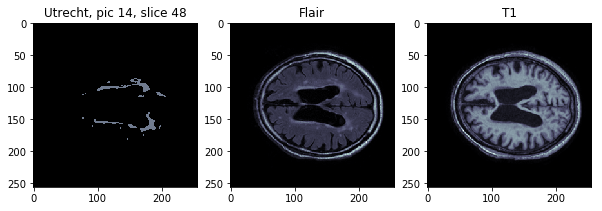

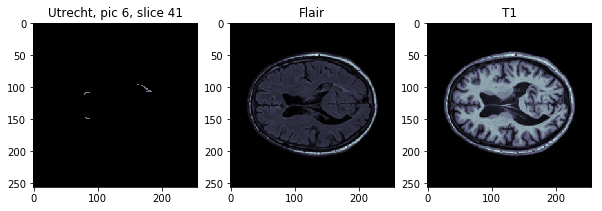

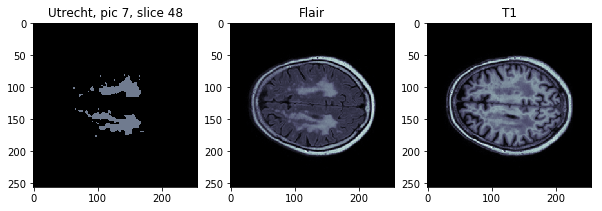

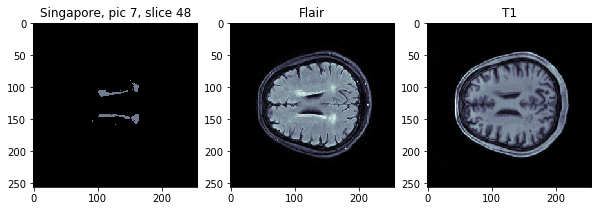

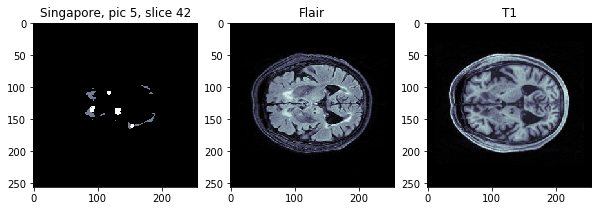

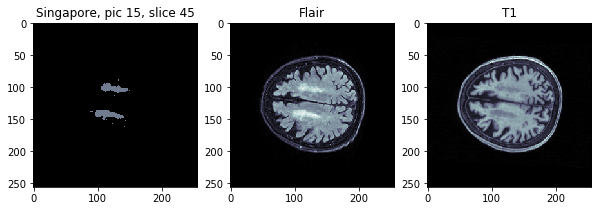

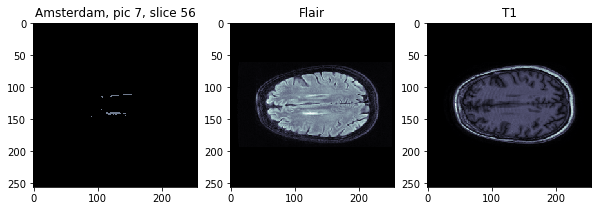

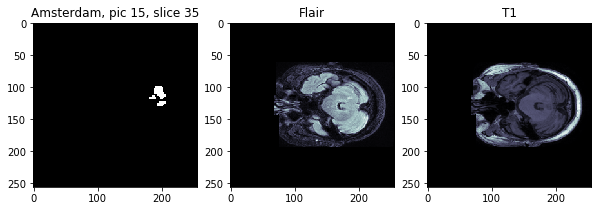

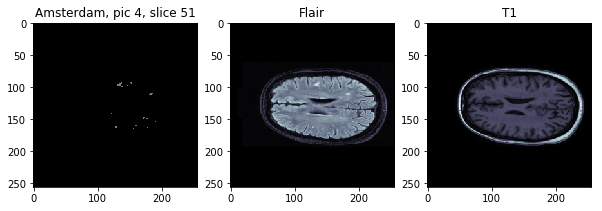

In [4]:
# Visualize

for pic in np.random.choice(range(len(masks)), 3, False):
    plt.figure(figsize=(10,10))
    mask = masks[pic, 0]
    flair = brains[pic, 0]
    tttt = brains[pic, 1]
    t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
    plt.subplot(1,3,1)
    plt.title('Utrecht, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,3,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

for pic in np.random.choice(range(len(masks1)), 3, False):
    plt.figure(figsize=(10,10))
    mask = masks1[pic, 0]
    flair = brains1[pic, 0]
    tttt = brains1[pic, 1]
    t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
    plt.subplot(1,3,1)
    plt.title('Singapore, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,3,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

for pic in np.random.choice(range(len(masks2)), 3, False):
    plt.figure(figsize=(10,10))
    mask = masks2[pic, 0]
    flair = brains2[pic, 0]
    tttt = brains2[pic, 1]
    t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
    plt.subplot(1,3,1)
    plt.title('Amsterdam, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,3,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

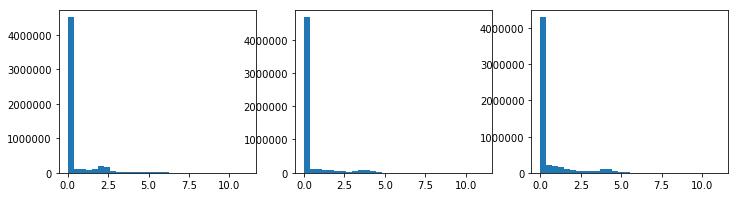

In [5]:
plt.figure(figsize=(12,3))
plt.title('hist of flairs');
plt.subplot(131)
a = plt.hist(brains[8, 0].flatten(), bins=30);
plt.subplot(132)
plt.hist(brains1[8, 0].flatten(), bins=a[1]);
plt.subplot(133)
plt.hist(brains2[8, 0].flatten(), bins=a[1]);

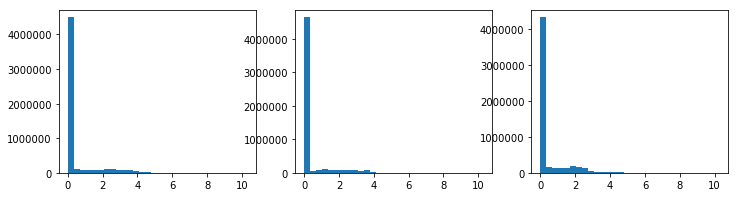

In [6]:
plt.figure(figsize=(12,3))
plt.title('hist of t1')
plt.subplot(131)
a = plt.hist(brains[8, 1].flatten(), bins=30);
plt.subplot(132)
plt.hist(brains1[8, 1].flatten(), bins=a[1]);
plt.subplot(133)
plt.hist(brains2[8, 1].flatten(), bins=a[1]);

____

In [7]:
def get_train_split(get_train_split=20, n=15):
    return np.in1d(np.array(range(get_train_split)), 
                   np.random.choice(range(get_train_split), n, False))

In [8]:
idx1, idx2, idx3 = get_train_split(), get_train_split(), get_train_split()
idx1, idx2, idx3

(array([ True,  True,  True, False, False,  True,  True,  True,  True,
         True, False,  True, False, False,  True,  True,  True,  True,
         True,  True], dtype=bool),
 array([ True,  True,  True,  True,  True,  True,  True, False, False,
         True, False,  True,  True,  True,  True,  True,  True, False,
        False,  True], dtype=bool),
 array([ True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,
        False, False], dtype=bool))

In [9]:
idx1, idx2, idx3 = (np.array([ True,  True,  True,  True,  True,  True, False,  True, False,
         True,  True, False,  True,  True,  True,  True,  True, False,
        False,  True], dtype=bool),
 np.array([ True,  True,  True,  True, False, False, False,  True,  True,
         True,  True,  True, False,  True, False,  True,  True,  True,
         True,  True], dtype=bool),
 np.array([ True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True,  True, False,
         True, False], dtype=bool))

In [10]:
#train_test_split
X_train = np.concatenate([brains[idx1], brains1[idx2], brains2[idx3]])
X_test = np.concatenate([brains[~idx1], brains1[~idx2], brains2[~idx3]])
Y_train = np.concatenate([masks[idx1], masks1[idx2], masks2[idx3]])
Y_test = np.concatenate([masks[~idx1], masks1[~idx2], masks2[~idx3]])

X_train = np.concatenate([brains[idx1]])
X_test = np.concatenate([brains[~idx1]])
Y_train = np.concatenate([masks[idx1]])
Y_test = np.concatenate([masks[~idx1]])

In [11]:
X_train.shape, X_test.shape

((45, 2, 256, 256, 84), (15, 2, 256, 256, 84))

In [12]:
del brains, brains1, brains2, masks, masks1, masks2

___

In [13]:
# архитектура которая смотрит больший конектст и предсказывает мелкий
# оптимизировать дайс

model = ENet(3, 2).cuda()

In [14]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_of_patches = 500
batch_size = 40
epoches = 100

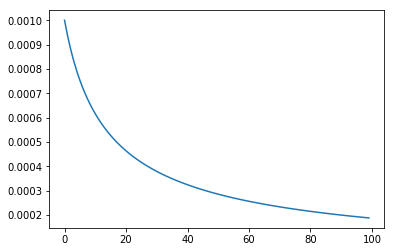

In [15]:
plt.plot([learning_rate / (1 + 10 * epoch / epoches) ** 0.7 for epoch in range(epoches)])

____

In [16]:
lr_arr = []
tr_loss_arr = []
val_loss_arr = []

In [17]:
def train(epoch, prev_inp, prev_targ, hard_neg_mining=True):
    """
    Train procedure.
    """
    # TODO assertation on crops to Network! 
    global optimizer
    global epoches
    
    ep = 'Epoch %d: ' % epoch
    mean_loss, step = 0, 0
    model.train()
    # augm all brains with elastic transformations
    
    inputs, targets = random_nonzero_crops(X_train, Y_train, num_of_patches, 
                                           shape=(80, 80, 40), mode='half')
    if hard_neg_mining:
        print ('added', len(prev_inp), 'examples')
        inputs = np.concatenate([inputs, prev_inp])
        targets = np.concatenate([targets, prev_targ])
        
    # augmentation
    bar = tqdm(par_iterate_minibatches(inputs, targets, batch_size, augment, shuffle=False),
              total=inputs.shape[0] // batch_size)
    
#     bar = tqdm(iterate_minibatches(inputs, targets, batch_size, shuffle=False),
#               total=inputs.shape[0] // batch_size)
    
    for x, y_true in bar:
#         tmp = [augment(*i) for i in zip(x, y_true)]
#         x = np.array([t[0] for t in tmp])
#         y_true = np.array([t[1] for t in tmp])
        x = to_var(np.array(x)).cuda()
        y_true = to_var(np.array(y_true)).cuda()
        y_pred = model(x)
        batch_loss = loss_cross_entropy(y_pred, y_true).cpu()
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        del x, y_true, y_pred
        
        mean_loss += batch_loss.data[0]
        step += 1
        bar.set_description(ep + str(batch_loss.data[0])[:6])
    
    if epoch % 10 == 0 and epoch <= 107:
        _ = learning_rate / (1 + 10 * epoch / epoches) ** 0.7
        print ('lr', _)
        optimizer = torch.optim.Adam(model.parameters(), lr=_)
    
    for i in optimizer.param_groups:
        lr_arr.append(i['lr'])
        break
        
    idx = validate(epoch, inputs=inputs, targets=targets, hard_neg_mining=True)
    
    return mean_loss / step, inputs[idx], targets[idx]

In [18]:
def validate(epoch, inputs=None, targets=None, hard_neg_mining=False, part=30):
    """
    part: int,
        number of objects for negative mining.
    """
    ep = 'Epoch %d: ' % epoch
    mean_loss, step = 0, 0
    model.eval()
    if not hard_neg_mining:
        inputs, targets = random_nonzero_crops(X_test, Y_test, num_of_patches=150,
                                               shape=(80, 80, 40), mode='half')
        batch_size_ = batch_size
    else:
        batch_size_ = 1
        hard_neg_idx = []
        
    bar = tqdm(iterate_minibatches(inputs, targets, batch_size_, shuffle=False),
              total=inputs.shape[0] // batch_size)
    
    for x, y_true in bar:
        x = to_var(x, volatile=True).cuda()
        y_true = to_var(y_true, volatile=True).cuda()
        y_pred = model.forward(x)
        
        batch_loss = loss_cross_entropy(y_pred, y_true).cpu()
        
        del x, y_true
        
        mean_loss += batch_loss.data[0]
        if hard_neg_mining:
            hard_neg_idx.append(batch_loss.data[0])
        
        step += 1
        bar.set_description(ep + str(batch_loss.data[0])[:6])
        
    if hard_neg_mining:
        return np.argsort(np.array(hard_neg_idx))[::-1][:part]
    return mean_loss / step

In [19]:
def validate_nuts(epch, visualize = False):
    shape = X_test.shape
    n_parts_per_axis = [1, 1, 8, 8, 4]
    padding = [0, 0, 16, 16, 10]
    zero_padding = [0] * 5
    xxx = _reshape_to(X_test[..., :80], (15, 2, 288, 288, 100))
    a_parts = divide(xxx, padding, n_parts_per_axis)
    pred = []
    model.eval()
    for i in a_parts:
        i = to_var(i).cuda()
        pred.append(to_numpy(model(i)))
    a_2 = combine(pred, n_parts_per_axis)
    
    y_pred = np.logical_and(a_2[:, 1, ...] > a_2[:, 0, ...],
                            a_2[:, 1, ...] > a_2[:, 2, ...])
    
    if visualize:
        for i in range(len(X_test)):
            t = np.argmax(np.sum(Y_test[i,0, ..., :80], axis=(-2, -3)))
            plt.figure()
            plt.subplot(121)
            plt.title('predicted ' + str(dice(y_pred[i], Y_test[i,0, ..., :80]))[:5] )
            plt.imshow(y_pred[i, ..., t], cmap=plt.cm.bone)
            plt.subplot(122)
            plt.title('ground_truth')
            plt.imshow(Y_test[i,0, ..., t], cmap=plt.cm.bone, vmax=2);
            plt.savefig('../reports/figures/'+str(i)+'.png')
            
        with open('../reports/README.md', 'w') as f:
            for i in range(len(X_test)):
                f.write('![./figures/'+str(i)+'.png](./figures/'+str(i)+'.png)\n')
    
#     return a_2
#     return ([dice(y_pred[i], Y_test[i,0]) for i in range(len(X_test))], 
#             [hausdorff(y_pred[i].astype(int),
#                        Y_test[i,0].astype(int), label=1)  
#              for i in range(len(X_test))])

_____

starting train for 100 epoches


Epoch 0: 1.0920:  42%|████▏     | 5/12 [00:00<00:00, 43.56it/s]

lr 0.001


Epoch 0: 1.0922: 503it [00:11, 43.53it/s]                       
Epoch 0: 1.0924: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


added 30 examples


Epoch 1: 0.9459: 100%|██████████| 13/13 [00:18<00:00,  1.38s/it]
Epoch 1: 1.0145: 533it [00:12, 43.33it/s]                       
Epoch 1: 1.0093: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 2: 0.7686: 100%|██████████| 13/13 [00:19<00:00,  1.36s/it]
Epoch 2: 0.8308: 531it [00:12, 43.18it/s]                       
Epoch 2: 0.8007: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 3: 0.5929: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 3: 0.6616: 543it [00:12, 42.59it/s]                       
Epoch 3: 0.5864: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 4: 0.4810: 100%|██████████| 13/13 [00:18<00:00,  1.35s/it]
Epoch 4: 0.5627: 531it [00:12, 43.47it/s]                       
Epoch 4: 0.4283: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 5: 0.3740: 100%|██████████| 13/13 [00:19<00:00,  1.38s/it]
Epoch 5: 0.4718: 535it [00:12, 43.40it/s]                      
Epoch 5: 0.3015: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 6: 0.3598: 100%|██████████| 13/13 [00:18<00:00,  1.33s/it]
Epoch 6: 0.4415: 530it [00:12, 43.12it/s]                       
Epoch 6: 0.2157: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 7: 0.2677: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]
Epoch 7: 0.4458: 537it [00:12, 42.16it/s]                       
Epoch 7: 0.1904: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 8: 0.1734: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 8: 0.4715: 546it [00:12, 43.33it/s]                       
Epoch 8: 0.1350: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 9: 0.2142: 100%|██████████| 13/13 [00:19<00:00,  1.38s/it]
Epoch 9: 0.4898: 540it [00:12, 43.54it/s]                      
Epoch 9: 0.1263: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 10: 0.0579:  31%|███       | 4/13 [00:00<00:00, 33.41it/s]

lr 0.0006155722066724582


Epoch 10: 0.5054: 539it [00:12, 43.30it/s]                       
Epoch 10: 0.1032: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 11: 0.1772: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]
Epoch 11: 0.5566: 541it [00:12, 43.19it/s]                       
Epoch 11: 0.0867: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 12: 0.2098: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 12: 0.5804: 542it [00:12, 42.40it/s]                       
Epoch 13: 0.1126: 100%|██████████| 12/12 [00:17<00:00,  1.34s/it]
Epoch 13: 0.0379: 505it [00:11, 43.11it/s]                       
Epoch 13: 0.1264: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 14: 0.2036: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 14: 0.3540: 537it [00:12, 43.03it/s]                       
Epoch 14: 0.0627: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 15: 0.0831: 100%|██████████| 13/13 [00:19<00:00,  1.41s/it]
Epoch 15: 0.3726: 549it [00:12, 43.30it/s]                      
Epoch 15: 0.0761: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 16: 0.3148: 100%|██████████| 13/13 [00:18<00:00,  1.32s/it]
Epoch 16: 0.4925: 535it [00:12, 43.43it/s]                       
Epoch 16: 0.0676: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 17: 0.1952: 100%|██████████| 13/13 [00:18<00:00,  1.35s/it]
Epoch 17: 0.4929: 541it [00:12, 43.32it/s]                      
Epoch 17: 0.0720: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 18: 0.2855: 100%|██████████| 13/13 [00:18<00:00,  1.35s/it]
Epoch 18: 0.5098: 534it [00:12, 43.20it/s]                       
Epoch 18: 0.0639: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 19: 0.2228: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 19: 0.5756: 540it [00:12, 43.50it/s]                       
Epoch 19: 0.0896: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 20: 0.0283:  38%|███▊      | 5/13 [00:00<00:00, 43.20it/s]

lr 0.0004634630567719698


Epoch 20: 0.5849: 544it [00:13, 42.12it/s]                       
Epoch 20: 0.0744: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 21: 0.1890: 100%|██████████| 13/13 [00:21<00:00,  1.51s/it]
Epoch 21: 0.6011: 542it [00:12, 42.01it/s]                      
Epoch 21: 0.0659: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 22: 0.2090: 100%|██████████| 13/13 [00:21<00:00,  1.49s/it]
Epoch 22: 0.6084: 540it [00:12, 42.71it/s]                       
Epoch 22: 0.0570: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 23: 0.3300: 100%|██████████| 13/13 [00:21<00:00,  1.49s/it]
Epoch 23: 0.6435: 533it [00:12, 42.38it/s]                       
Epoch 23: 0.0617: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 24: 0.2159: 100%|██████████| 13/13 [00:19<00:00,  1.39s/it]
Epoch 24: 0.6128: 539it [00:12, 42.85it/s]                       
Epoch 24: 0.0883: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 25: 0.2284: 100%|██████████| 13/13 [00:18<00:00,  1.38s/it]
Epoch 25: 0.6223: 538it [00:12, 42.97it/s]                       
Epoch 26: 0.0402: 100%|██████████| 12/12 [00:18<00:00,  1.43s/it]
Epoch 26: 0.0103: 511it [00:11, 43.06it/s]                      
Epoch 26: 0.0664: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 27: 0.1893: 100%|██████████| 13/13 [00:19<00:00,  1.38s/it]
Epoch 27: 0.2227: 535it [00:12, 42.71it/s]                       
Epoch 27: 0.0768: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 28: 0.1999: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]
Epoch 28: 0.3196: 540it [00:12, 43.07it/s]                      
Epoch 28: 0.0883: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 29: 0.2122: 100%|██████████| 13/13 [00:19<00:00,  1.40s/it]
Epoch 29: 0.3300: 539it [00:12, 43.06it/s]                       
Epoch 29: 0.0643: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 30: 0.1005:  38%|███▊      | 5/13 [00:00<00:00, 43.33it/s]

lr 0.00037892914162759953


Epoch 30: 0.4388: 530it [00:12, 43.38it/s]                       
Epoch 30: 0.0628: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 31: 0.2658: 100%|██████████| 13/13 [00:18<00:00,  1.36s/it]
Epoch 31: 0.5064: 530it [00:12, 43.24it/s]                       
Epoch 31: 0.0698: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 32: 0.2184: 100%|██████████| 13/13 [00:18<00:00,  1.36s/it]
Epoch 32: 0.4929: 537it [00:12, 43.35it/s]                       
Epoch 32: 0.0720: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 33: 0.2536: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 33: 0.4739: 536it [00:12, 43.16it/s]                       
Epoch 33: 0.0527: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 34: 0.1797: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 34: 0.4963: 540it [00:12, 43.37it/s]                       
Epoch 34: 0.0653: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 35: 0.2050: 100%|██████████| 13/13 [00:18<00:00,  1.32s/it]
Epoch 35: 0.5918: 539it [00:12, 43.34it/s]                      
Epoch 35: 0.0567: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 36: 0.2619: 100%|██████████| 13/13 [00:19<00:00,  1.40s/it]
Epoch 36: 0.5408: 537it [00:12, 43.02it/s]                       
Epoch 36: 0.0520: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 37: 0.1392: 100%|██████████| 13/13 [00:18<00:00,  1.33s/it]
Epoch 37: 0.5414: 545it [00:12, 43.27it/s]                       
Epoch 37: 0.0658: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 38: 0.2126: 100%|██████████| 13/13 [00:19<00:00,  1.37s/it]
Epoch 38: 0.5338: 539it [00:12, 42.57it/s]                       
Epoch 39: 0.0638: 100%|██████████| 12/12 [00:17<00:00,  1.38s/it]
Epoch 39: 0.0291: 512it [00:11, 43.17it/s]                      
Epoch 39: 0.0585: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 40: 0.0752:  31%|███       | 4/13 [00:00<00:00, 38.77it/s]

lr 0.0003241313193385525


Epoch 40: 0.1909: 540it [00:12, 43.15it/s]                       
Epoch 40: 0.0527: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 41: 0.1323: 100%|██████████| 13/13 [00:18<00:00,  1.30s/it]
Epoch 41: 0.2680: 543it [00:12, 43.33it/s]                      
Epoch 41: 0.0497: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 42: 0.2122: 100%|██████████| 13/13 [00:18<00:00,  1.33s/it]
Epoch 42: 0.2911: 538it [00:12, 43.09it/s]                       
Epoch 42: 0.0461: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 43: 0.2608: 100%|██████████| 13/13 [00:18<00:00,  1.35s/it]
Epoch 43: 0.3328: 531it [00:12, 43.31it/s]                      
Epoch 43: 0.0667: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 44: 0.1005: 100%|██████████| 13/13 [00:19<00:00,  1.42s/it]
Epoch 44: 0.3459: 546it [00:12, 43.24it/s]                       
Epoch 44: 0.0528: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 45: 0.2284: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 45: 0.3566: 536it [00:12, 42.56it/s]                       
Epoch 45: 0.0536: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 46: 0.2297: 100%|██████████| 13/13 [00:18<00:00,  1.33s/it]
Epoch 46: 0.3706: 537it [00:12, 43.40it/s]                       
Epoch 46: 0.0687: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 47: 0.2095: 100%|██████████| 13/13 [00:19<00:00,  1.34s/it]
Epoch 47: 0.4296: 538it [00:12, 43.35it/s]                      
Epoch 47: 0.0596: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 48: 0.1723: 100%|██████████| 13/13 [00:18<00:00,  1.33s/it]
Epoch 48: 0.3949: 542it [00:12, 43.08it/s]                       
Epoch 48: 0.0401: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 49: 0.2802: 100%|██████████| 13/13 [00:18<00:00,  1.33s/it]
Epoch 49: 0.4891: 535it [00:12, 43.41it/s]                       
Epoch 49: 0.0753: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 50: 0.0057:  31%|███       | 4/13 [00:00<00:00, 33.30it/s]

lr 0.0002852949765682842


Epoch 50: 0.4535: 532it [00:12, 43.30it/s]                       
Epoch 50: 0.0383: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 51: 0.3124: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 51: 0.5097: 534it [00:12, 42.77it/s]                       
Epoch 52: 0.0568: 100%|██████████| 12/12 [00:17<00:00,  1.34s/it]
Epoch 52: 0.0333: 510it [00:12, 42.19it/s]                       
Epoch 52: 0.0425: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 53: 0.1029: 100%|██████████| 13/13 [00:18<00:00,  1.36s/it]
Epoch 53: 0.1869: 537it [00:12, 43.13it/s]                       
Epoch 53: 0.0420: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 54: 0.1694: 100%|██████████| 13/13 [00:18<00:00,  1.38s/it]
Epoch 54: 0.2579: 531it [00:12, 43.49it/s]                       
Epoch 54: 0.0792: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 55: 0.1596: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]
Epoch 55: 0.2607: 535it [00:12, 43.09it/s]                       
Epoch 55: 0.0763: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 56: 0.1543: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it]
Epoch 56: 0.3834: 541it [00:12, 42.15it/s]                       
Epoch 56: 0.0557: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 57: 0.1316: 100%|██████████| 13/13 [00:21<00:00,  1.49s/it]
Epoch 57: 0.3662: 546it [00:12, 42.10it/s]                       
Epoch 57: 0.0588: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 58: 0.0884: 100%|██████████| 13/13 [00:23<00:00,  1.58s/it]
Epoch 58: 0.3250: 545it [00:12, 42.06it/s]                       
Epoch 58: 0.0489: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 59: 0.2315: 100%|██████████| 13/13 [00:22<00:00,  1.53s/it]
Epoch 59: 0.3553: 533it [00:12, 41.55it/s]                       
Epoch 59: 0.0559: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 60: 0.0300:  31%|███       | 4/13 [00:00<00:00, 35.94it/s]

lr 0.0002561128517887139


Epoch 60: 0.3596: 535it [00:12, 43.30it/s]                       
Epoch 60: 0.0478: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 61: 0.2635: 100%|██████████| 13/13 [00:18<00:00,  1.35s/it]
Epoch 61: 0.4560: 531it [00:12, 43.26it/s]                      
Epoch 61: 0.0633: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 62: 0.1783: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]
Epoch 62: 0.4110: 539it [00:12, 43.28it/s]                       
Epoch 62: 0.0570: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 63: 0.1231: 100%|██████████| 13/13 [00:18<00:00,  1.33s/it]
Epoch 63: 0.3604: 545it [00:12, 43.35it/s]                      
Epoch 63: 0.0431: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 64: 0.1225: 100%|██████████| 13/13 [00:18<00:00,  1.33s/it]
Epoch 64: 0.4299: 544it [00:12, 43.46it/s]                      
Epoch 65: 0.0302: 100%|██████████| 12/12 [00:17<00:00,  1.37s/it]
Epoch 65: 0.0022: 507it [00:11, 43.28it/s]                       
Epoch 65: 0.0498: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 66: 0.1132: 100%|██████████| 13/13 [00:19<00:00,  1.38s/it]
Epoch 66: 0.1624: 545it [00:12, 43.42it/s]                       
Epoch 66: 0.0474: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 67: 0.2040: 100%|██████████| 13/13 [00:18<00:00,  1.30s/it]
Epoch 67: 0.2438: 535it [00:12, 43.61it/s]                       
Epoch 67: 0.0494: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 68: 0.1821: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 68: 0.2610: 538it [00:12, 43.35it/s]                       
Epoch 68: 0.0417: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 69: 0.1956: 100%|██████████| 13/13 [00:18<00:00,  1.32s/it]
Epoch 69: 0.3142: 536it [00:12, 43.31it/s]                       
Epoch 69: 0.0531: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 70: 0.1949:  38%|███▊      | 5/13 [00:00<00:00, 41.42it/s]

lr 0.00023325824788420188


Epoch 70: 0.3152: 534it [00:12, 43.09it/s]                       
Epoch 70: 0.0509: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 71: 0.2520: 100%|██████████| 13/13 [00:21<00:00,  1.56s/it]
Epoch 71: 0.3252: 535it [00:12, 42.50it/s]                      
Epoch 71: 0.0659: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 72: 0.3169: 100%|██████████| 13/13 [00:21<00:00,  1.51s/it]
Epoch 72: 0.3368: 530it [00:12, 42.44it/s]                      
Epoch 72: 0.0386: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 73: 0.1429: 100%|██████████| 13/13 [00:21<00:00,  1.56s/it]
Epoch 73: 0.3739: 541it [00:12, 42.57it/s]                       
Epoch 73: 0.0644: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 74: 0.2449: 100%|██████████| 13/13 [00:21<00:00,  1.44s/it]
Epoch 74: 0.3625: 537it [00:12, 42.90it/s]                       
Epoch 74: 0.0564: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 75: 0.2074: 100%|██████████| 13/13 [00:21<00:00,  1.53s/it]
Epoch 75: 0.3780: 540it [00:12, 42.46it/s]                       
Epoch 75: 0.0380: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 76: 0.2946: 100%|██████████| 13/13 [00:21<00:00,  1.59s/it]
Epoch 76: 0.3983: 531it [00:12, 42.60it/s]                       
Epoch 76: 0.0545: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 77: 0.2658: 100%|██████████| 13/13 [00:22<00:00,  1.56s/it]
Epoch 77: 0.3733: 534it [00:12, 42.15it/s]                      
Epoch 78: 0.0544: 100%|██████████| 12/12 [00:20<00:00,  1.54s/it]
Epoch 78: 0.0161: 506it [00:11, 42.43it/s]                       
Epoch 78: 0.0570: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 79: 0.1306: 100%|██████████| 13/13 [00:21<00:00,  1.55s/it]
Epoch 79: 0.1828: 536it [00:12, 42.60it/s]                       
Epoch 79: 0.0642: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 80: 0.0346:  38%|███▊      | 5/13 [00:00<00:00, 43.29it/s]

lr 0.0002147980049924181


Epoch 80: 0.2365: 546it [00:12, 42.06it/s]                       
Epoch 80: 0.0690: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 81: 0.2317: 100%|██████████| 13/13 [00:21<00:00,  1.50s/it]
Epoch 81: 0.2698: 530it [00:12, 42.38it/s]                       
Epoch 81: 0.0676: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 82: 0.1299: 100%|██████████| 13/13 [00:21<00:00,  1.54s/it]
Epoch 82: 0.3220: 543it [00:12, 42.59it/s]                       
Epoch 82: 0.0548: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 83: 0.1093: 100%|██████████| 13/13 [00:21<00:00,  1.55s/it]
Epoch 83: 0.3287: 544it [00:12, 42.56it/s]                      
Epoch 83: 0.0482: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 84: 0.1645: 100%|██████████| 13/13 [00:21<00:00,  1.57s/it]
Epoch 84: 0.3184: 536it [00:12, 42.74it/s]                       
Epoch 84: 0.0622: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 85: 0.2347: 100%|██████████| 13/13 [00:21<00:00,  1.53s/it]
Epoch 85: 0.3506: 532it [00:12, 41.67it/s]                       
Epoch 85: 0.0389: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 86: 0.2419: 100%|██████████| 13/13 [00:21<00:00,  1.51s/it]
Epoch 86: 0.3244: 531it [00:12, 42.05it/s]                      
Epoch 86: 0.0598: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 87: 0.1232: 100%|██████████| 13/13 [00:21<00:00,  1.56s/it]
Epoch 87: 0.3303: 543it [00:12, 42.56it/s]                       
Epoch 87: 0.0547: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 88: 0.2126: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 88: 0.3596: 536it [00:12, 43.13it/s]                       
Epoch 88: 0.0610: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 89: 0.1638: 100%|██████████| 13/13 [00:18<00:00,  1.37s/it]
Epoch 89: 0.3902: 541it [00:12, 43.16it/s]                       
Epoch 89: 0.0529: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 90: 0.0954:  31%|███       | 4/13 [00:00<00:00, 35.09it/s]

lr 0.000199526231496888


Epoch 90: 0.3874: 533it [00:12, 42.64it/s]                       
Epoch 91: 0.0282: 100%|██████████| 12/12 [00:17<00:00,  1.36s/it]
Epoch 91: 0.0267: 501it [00:11, 43.15it/s]                      
Epoch 91: 0.0359: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 92: 0.1067: 100%|██████████| 13/13 [00:18<00:00,  1.31s/it]
Epoch 92: 0.1725: 538it [00:12, 43.25it/s]                       
Epoch 92: 0.0390: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 93: 0.1274: 100%|██████████| 13/13 [00:19<00:00,  1.38s/it]
Epoch 93: 0.2323: 541it [00:12, 43.10it/s]                       
Epoch 93: 0.0362: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 94: 0.1568: 100%|██████████| 13/13 [00:19<00:00,  1.42s/it]
Epoch 94: 0.2935: 534it [00:12, 43.48it/s]                       
Epoch 94: 0.0423: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 95: 0.1921: 100%|██████████| 13/13 [00:19<00:00,  1.36s/it]
Epoch 95: 0.2994: 535it [00:12, 43.10it/s]                      
Epoch 95: 0.0473: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 96: 0.1403: 100%|██████████| 13/13 [00:18<00:00,  1.35s/it]
Epoch 96: 0.3887: 540it [00:12, 42.27it/s]                       
Epoch 96: 0.0608: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 97: 0.2186: 100%|██████████| 13/13 [00:18<00:00,  1.30s/it]
Epoch 97: 0.3386: 533it [00:12, 43.11it/s]                       
Epoch 97: 0.0389: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


added 30 examples


Epoch 98: 0.2008: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]
Epoch 98: 0.3355: 533it [00:12, 43.06it/s]                       
Epoch 98: 0.0575: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


added 30 examples


Epoch 99: 0.1867: 100%|██████████| 13/13 [00:18<00:00,  1.34s/it]
Epoch 99: 0.3765: 536it [00:12, 42.69it/s]                       
Epoch 99: 0.0410: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


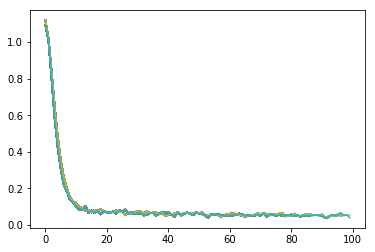

In [20]:
print ('starting train for {} epoches'.format(epoches))
with open('../reports/logs/nnet_out.txt', 'w') as f:
    f.write('\nBegin at'+str(datetime.now())[:19]+'\n')
        
prev_inp, prev_targ = [], []
for epoch in range(epoches):
    tr_loss, prev_inp, prev_targ = train(epoch, prev_inp, prev_targ, epoch>=1 and epoch%13!=0)
    test_loss = validate(epoch)
    tr_loss_arr.append(tr_loss)
    val_loss_arr.append(test_loss)
    with open('../reports/logs/nnet_out.txt', 'a') as f:
        f.write('\nEpoch:'+str(epoch))
        f.write('\n  Train logloss '+ str(tr_loss))
        f.write('\n  Test logloss '+ str(test_loss))
        f.close()
    plt.plot(tr_loss_arr, label='Train')
    plt.plot(val_loss_arr, label='val')
    plt.legend
    plt.savefig('../reports/logs/losses.png')

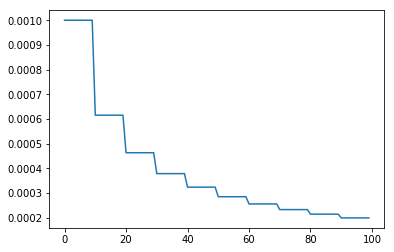

In [21]:
plt.plot(lr_arr)

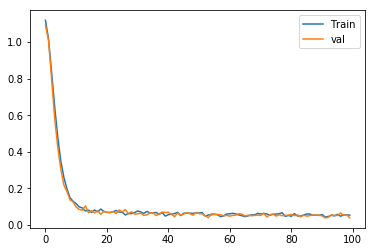

In [22]:
plt.plot(tr_loss_arr, label='Train')
plt.plot(val_loss_arr, label='val')
plt.legend()

______

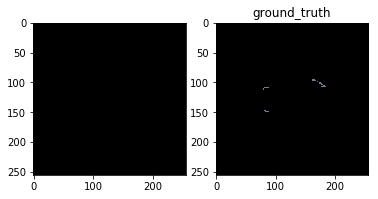

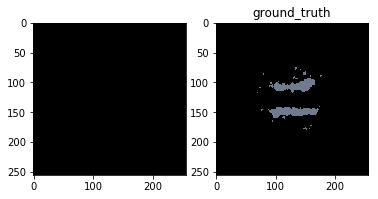

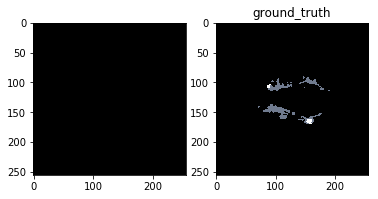

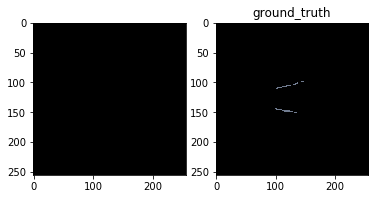

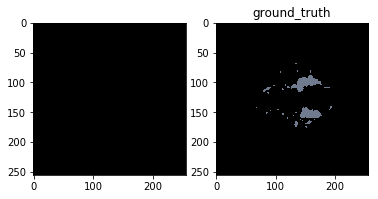

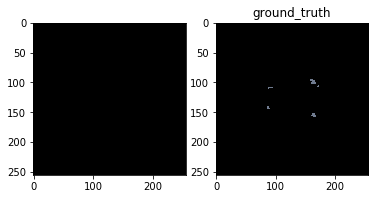

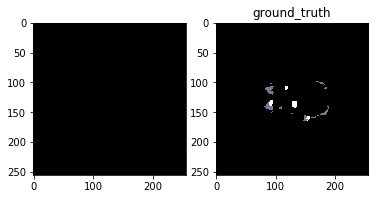

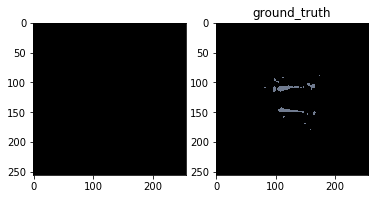

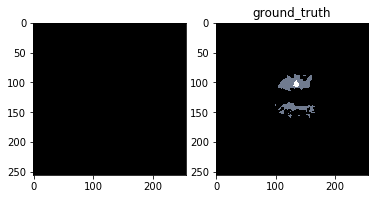

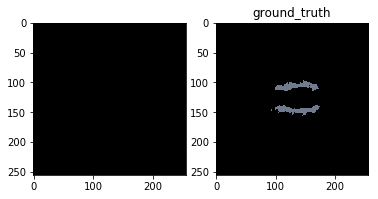

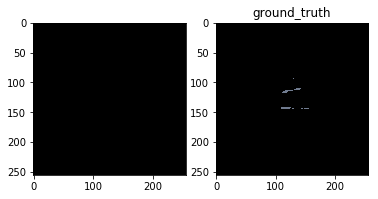

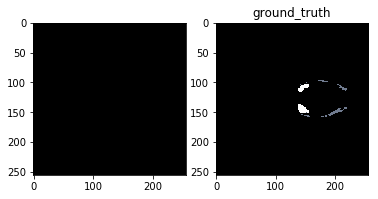

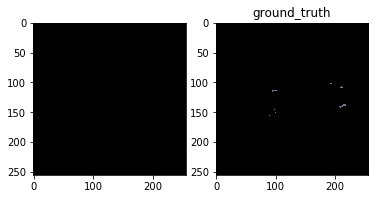

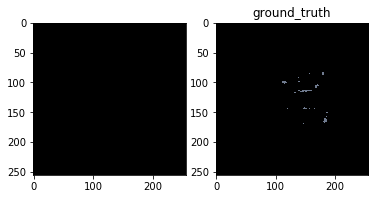

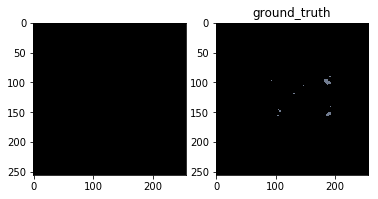

In [23]:
a = validate_nuts(0, True)

_____

In [ ]:
import pickle
with open('../models/dumps/model_enetcnn.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f, protocol=pickle.HIGHEST_PROTOCOL)

___

In [ ]:
import pickle
with open('../models/dumps/model_enetcnn.pkl', 'rb') as f:
    model_dict = pickle.load(f)
model.load_state_dict(model_dict)

___